# LA COVID-19: APARICIÓN DE NUEVOS PATRONES DE CONSUMO
<table><tr>
<td> <img src="https://www.agilitypr.com/wp-content/uploads/2020/03/corona-1-3.jpg" alt="Drawing" style="width: 700px;"/> </td>
<td> <img src="https://blog.cybba.com/hubfs/539.jpg" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

Fuente de los datos: https://www.mapa.gob.es/app/consumo-en-hogares/consulta11.asp

*Los datos hacen referencia al consumo por producto y por lugar de venta (en supermercados, hipermercados e internet) para poder analizar cómo la COVID19 (en concreto durante el estado de alarma) afectó al comercio físico y al online.*

In [1]:
# Se cargan todas las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgbm
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score
from sklearn.decomposition import PCA

In [2]:
# Se cargan todos los datasets y se juntan en uno solo para hacer un análisis de las variables
df_fi = pd.read_csv("Consumo_2013_2020_frutas_internet.csv", encoding = 'utf-8-sig')
df_hi = pd.read_csv("Consumo_2013_2020_hortalizas_internet.csv", encoding = 'utf-8-sig')
df_hh = pd.read_csv("Consumo_2013_2020_hortalizas_hipermercado.csv", encoding = 'utf-8-sig')
df_fh = pd.read_csv("Consumo_2013_2020_frutas_hipermercado.csv", encoding = 'utf-8-sig')
df_fs = pd.read_csv("Consumo_2013_2020_frutas_supermercado.csv", encoding = 'utf-8-sig')
df_hs = pd.read_csv("Consumo_2013_2020_hortalizas_supermercado.csv", encoding = 'utf-8-sig')
df_internet = pd.concat([df_hi,df_fi], axis = 0)
df_hipermercado = pd.concat([df_hh,df_fh], axis = 0)
df_supermercado = pd.concat([df_hs,df_fs], axis = 0)
df_total = pd.concat([df_internet,df_hipermercado,df_supermercado], axis = 0)

## MES CON MAYOR PENETRACIÓN PARA FRUTAS, HORTALIZAS Y PATATAS TOTALES EN FUNCIÓN DEL CANAL DE VENTA

### PATRÓN DE CONSUMO 1 : COMPRA ONLINE (INTERNET)

In [3]:
df_tot_hi = df_internet[(df_internet['Año'] == 2020) & (df_internet['Producto'] == 'T.HORTALIZAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_hi

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1999,04-2020,T.HORTALIZAS FRESCAS,6031.79,13855.79,0.23,6.15,INTERNET,2020,4


In [4]:
df_tot_fi = df_internet[(df_internet['Año'] == 2020) & (df_internet['Producto'] == 'T.FRUTAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_fi

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1920,04-2020,T.FRUTAS FRESCAS,8530.71,16284.75,1.91,6.61,INTERNET,2020,4


In [5]:
df_tot_pi = df_internet[(df_internet['Año'] == 2020) & (df_internet['Producto'] == 'TOTAL PATATAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_pi

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1994,04-2020,TOTAL PATATAS,4115.36,4557.42,1.11,3.84,INTERNET,2020,4


En ambos casos se observa que el mes con más venta por internet fue en abril cuando ya se estaba en el estado de alarma y la gente tenía miedo a ir a los supermercados (además de que el aforo estaba muy reducido) y comenzaron a realizar la compra online. 

### PATRÓN DE CONSUMO 2: COMPRA FÍSICA (SUPERMERCADO E HIPERMERCADO)

- SUPERMERCADO

In [6]:
df_tot_hs = df_supermercado[(df_supermercado['Año'] == 2020) & (df_supermercado['Producto'] == 'T.HORTALIZAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_hs

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1995,04-2020,T.HORTALIZAS FRESCAS,152317.65,317143.67,2.08,90.33,SUPERMERCADO,2020,4


In [7]:
df_tot_fs = df_supermercado[(df_supermercado['Año'] == 2020) & (df_supermercado['Producto'] == 'T.FRUTAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_fs

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1920,04-2020,T.FRUTAS FRESCAS,218281.19,385949.27,1.77,88.26,SUPERMERCADO,2020,4


In [8]:
df_tot_ps = df_supermercado[(df_supermercado['Año'] == 2020) & (df_supermercado['Producto'] == 'TOTAL PATATAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_ps

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1990,04-2020,TOTAL PATATAS,85606.89,92550.23,1.08,70.21,SUPERMERCADO,2020,4


- HIPERMERCADO

In [9]:
df_tot_hh = df_hipermercado[(df_hipermercado['Año'] == 2020) & (df_hipermercado['Producto'] == 'T.HORTALIZAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_hh

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1972,03-2020,T.HORTALIZAS FRESCAS,20909.08,42590.55,2.04,29.22,HIPERMERCADOS,2020,3


In [10]:
df_tot_fh = df_hipermercado[(df_hipermercado['Año'] == 2020) & (df_hipermercado['Producto'] == 'T.FRUTAS FRESCAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_fh

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1896,03-2020,T.FRUTAS FRESCAS,31735.81,52670.48,1.66,27.73,HIPERMERCADOS,2020,3


In [11]:
df_tot_ph = df_hipermercado[(df_hipermercado['Año'] == 2020) & (df_hipermercado['Producto'] == 'TOTAL PATATAS')].sort_values('Penetración (%)', ascending = False).head(1)
df_tot_ph

,Fecha,Producto,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Canal_Venta,Año,Mes
1967,03-2020,TOTAL PATATAS,15203.59,16228.21,1.07,16.98,HIPERMERCADOS,2020,3


*La conclusión que se obtiene de las siguientes tablas es que en el mes más duro del estado de alarma (marzo) la gente iba a los hipermercados a comprar porque eran lugares muy amplios donde era más complicado contagiarse. A medida que fue evolucionando el estado de alarma, la gente se fue adaptando y empezó a realizar la compra en los supermercados de su zona (por comodidad) y, sobre todo, destaca la compra online. La compra online que lleva creciendo varios años para la alimentación en general, no lo había hecho en el ámbito agrícola ya que la gente era reacia a comprar elementos frescos que no pudiesen ver como en los mercados. Sin embargo, la covid obligó a que también se comprasen esos productos online por eso se produce un gran crecimiento en el mes de abril.*

## VISUALIZACIÓN DE LOS DATOS

### EVOLUCIÓN DEL CONSUMO DESDE 2016 - 2020 : INTERNET VS SUPERMERCADO

In [12]:
from IPython.display import IFrame
IFrame("https://app.powerbi.com/view?r=eyJrIjoiNWNiNjM1YjItMzZmYi00MDgxLWI4MTQtMTJhMjlhZDgxNTAyIiwidCI6IjZhZmVhODVkLWMzMjMtNDI3MC1iNjlkLWE0ZmIzOTI3YzI1NCIsImMiOjl9",height= 550, width = 1000)

*Este informe expone la línea temporal del consumo total desde 2016 a 2020 en Internet y en los Supermercados. La finalidad es analizar los nuevos patrones de consumo que surgieron como consecuencia del estado de alarma (consecuencia del confinamiento).*

### EVOLUCIÓN DEL CONSUMO POR CADA LUGAR DE COMPRA 

In [13]:
from IPython.display import IFrame
IFrame("https://app.powerbi.com/view?r=eyJrIjoiMjIwOGEwNWItZWNhYy00NmYyLWFjODEtMzRlOTg2YjkyZTg3IiwidCI6IjZhZmVhODVkLWMzMjMtNDI3MC1iNjlkLWE0ZmIzOTI3YzI1NCIsImMiOjl9",height= 550, width = 1000)

*Este informe refleja : la evolución del consumo (miles de €) a lo largo del 2020 por canal de venta y consumo total (toneladas y miles de €) por cada canal de venta. De esta forma se puede visualizar si todos los canales de venta sigueron la misma tendencia y la cuota de mercado de cada canal.*


## PENETRACIÓN (%) DE HORTALIZAS Y FRUTAS - SUPERMERCADO VS INTERNET

In [14]:
from IPython.display import IFrame
IFrame("https://app.powerbi.com/view?r=eyJrIjoiMDdhMjk5ZDUtOTBkMy00ZTQwLTg5YmUtYmQ1NTFjN2E1MGQwIiwidCI6IjZhZmVhODVkLWMzMjMtNDI3MC1iNjlkLWE0ZmIzOTI3YzI1NCIsImMiOjl9",height= 550, width = 1000)

*Este reporte expone cómo ha ido variando la penetración (%) por cada producto desde el año 2013 al 2020. La primera pestaña hace referencia a las hortalizas y la segunda a las frutas. También se muestra el valor máximo de penetración de ese producto en ese periodo de tiempo. Con este reporte no solo podemos hacer un estudio de la estacionalidad de cada uno de los productos, sino también analizar el porqué de los valores atípicos de penetración de ciertos productos durante el periodo de excepción.*

Para visualizar el análisis completo, acudir a: https://datacrop.es/reto-analisis-5/

## ANÁLISIS ESTADÍSTICO DE LAS VARIABLES  

Text(0.5, 1.0, 'Estudio correlación con todos los canales juntos')

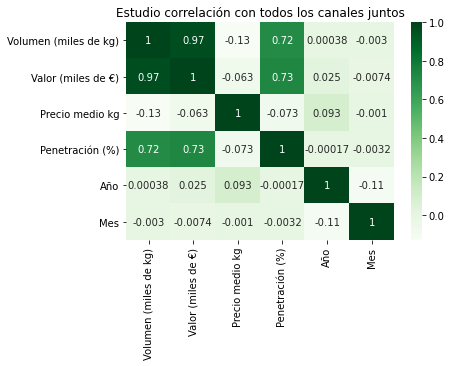

In [15]:
# Estudiamos la posible correlación entre las diferentes variables
sns.heatmap(df_total.corr(),annot=True, cmap= 'Greens').set_title("Estudio correlación con todos los canales juntos")

### MODELO DE MACHINE LEARNING PARA LA PREDICCIÓN DEL CONSUMO POR INTERNET

In [16]:
# Se quita la columna fecha
df_internet_modelo = df_internet.drop(columns = ['Fecha'])
# Se pasa la columna de Producto
of_style = OneHotEncoder()
of_results = of_style.fit_transform(df_internet[['Producto']])

In [17]:
# Se unen las nuevas columnas categóricas al dataframe
df_internet_modelo = df_internet_modelo.join(pd.DataFrame(of_results.toarray(), columns=of_style.categories_))
df_internet_modelo.drop(columns=['Canal_Venta','Producto'], inplace = True)

In [18]:
# Se ordena por mes y año y se establece la columna Año como índice
df_internet_modelo.reset_index(drop=True,inplace=True)
df_internet_modelo = df_internet_modelo.sort_values(by = ['Año','Mes'])
df_internet_modelo.set_index('Año', inplace = True)
df_internet_modelo

,Volumen (miles de kg),Valor (miles de €),Precio medio kg,Penetración (%),Mes,"(AGUACATE,)","(AJOS,)","(ALBARICOQUES,)","(ALCACHOFAS,)","(APIO,)",...,"(SANDIA,)","(T.FRUTAS FRESCAS,)","(T.HORTALIZAS FRESCAS,)","(TOMATES,)","(TOTAL PATATAS,)","(UVAS,)","(VERD./HORT. ECOLOGIC,)","(VERD./HORT. IV GAMA,)","(VERDURAS DE HOJA,)","(ZANAHORIAS,)"
Año,,,,,,,,,,,,,,,,,,,,,
2013,577.37,556.92,0.96,0.81,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013,1153.05,1596.45,1.38,1.43,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2013,352.30,291.06,0.83,0.42,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,556.26,668.21,0.12,0.52,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013,53.91,63.59,1.18,0.14,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,15.12,42.75,2.83,0.11,6,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020,47.58,80.49,1.69,0.25,6,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020,9.49,20.36,2.14,0.03,6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Se separa la variable objetivo (Y) - predicción consumo kg de las features (X)
y = df_internet_modelo['Volumen (miles de kg)']
X = df_internet_modelo
X.drop(columns = ['Volumen (miles de kg)','Valor (miles de €)'], inplace = True)

In [20]:
# Se separa el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Se inicializan los diferentes modelos 
xgb_model = xgb.XGBRegressor()
reg_model = lgbm.sklearn.LGBMRegressor()
cbr_model = CatBoostRegressor()

In [22]:
# Se construyen varias pipelines (es recomendable normalizar las variables antes de introducirlas en los modelos)
# sobre todo si se va a introducir PCA (reducción de dimensionalidad)
pipe = Pipeline([('std',StandardScaler()),('pca',PCA()),('model',xgb_model)])
pipe2 = Pipeline([('std',StandardScaler()),('pca',PCA()),('model',reg_model)])
pipe3 = Pipeline([('std',StandardScaler()),('pca',PCA()),('model',cbr_model)])

In [23]:
# Se entrenan los 3 modelos 
pipe.fit(X_train, y_train)
pipe2.fit(X_train, y_train)
pipe3.fit(X_train, y_train)

Learning rate set to 0.048149
0:	learn: 392.5201368	total: 146ms	remaining: 2m 26s
1:	learn: 385.4044875	total: 303ms	remaining: 2m 30s
2:	learn: 377.6720059	total: 311ms	remaining: 1m 43s
3:	learn: 370.3827500	total: 319ms	remaining: 1m 19s
4:	learn: 362.2091578	total: 328ms	remaining: 1m 5s
5:	learn: 354.1473581	total: 336ms	remaining: 55.6s
6:	learn: 347.4783304	total: 344ms	remaining: 48.8s
7:	learn: 340.1843609	total: 418ms	remaining: 51.8s
8:	learn: 333.0315760	total: 425ms	remaining: 46.8s
9:	learn: 326.8331388	total: 433ms	remaining: 42.8s
10:	learn: 320.3523844	total: 439ms	remaining: 39.5s
11:	learn: 314.1589381	total: 447ms	remaining: 36.8s
12:	learn: 308.9504770	total: 455ms	remaining: 34.6s
13:	learn: 303.5054415	total: 463ms	remaining: 32.6s
14:	learn: 298.1088924	total: 474ms	remaining: 31.1s
15:	learn: 292.9367378	total: 483ms	remaining: 29.7s
16:	learn: 288.0393434	total: 491ms	remaining: 28.4s
17:	learn: 284.2956329	total: 499ms	remaining: 27.2s
18:	learn: 279.2035849

165:	learn: 137.0919391	total: 1.56s	remaining: 7.86s
166:	learn: 136.9465053	total: 1.57s	remaining: 7.84s
167:	learn: 136.8128156	total: 1.58s	remaining: 7.81s
168:	learn: 136.6158418	total: 1.58s	remaining: 7.79s
169:	learn: 136.5023202	total: 1.59s	remaining: 7.77s
170:	learn: 136.3077553	total: 1.6s	remaining: 7.75s
171:	learn: 136.1931368	total: 1.6s	remaining: 7.73s
172:	learn: 135.9206428	total: 1.61s	remaining: 7.71s
173:	learn: 135.5794794	total: 1.62s	remaining: 7.69s
174:	learn: 135.1899484	total: 1.63s	remaining: 7.68s
175:	learn: 135.0714786	total: 1.64s	remaining: 7.66s
176:	learn: 134.8965941	total: 1.64s	remaining: 7.63s
177:	learn: 134.6899896	total: 1.65s	remaining: 7.62s
178:	learn: 134.5182739	total: 1.66s	remaining: 7.59s
179:	learn: 134.4110599	total: 1.66s	remaining: 7.57s
180:	learn: 134.0023231	total: 1.67s	remaining: 7.54s
181:	learn: 133.8821550	total: 1.67s	remaining: 7.52s
182:	learn: 133.6874179	total: 1.68s	remaining: 7.49s
183:	learn: 133.5527440	total:

329:	learn: 112.9677716	total: 2.55s	remaining: 5.19s
330:	learn: 112.9163460	total: 2.56s	remaining: 5.17s
331:	learn: 112.8729437	total: 2.57s	remaining: 5.16s
332:	learn: 112.8410579	total: 2.57s	remaining: 5.15s
333:	learn: 112.8039992	total: 2.58s	remaining: 5.14s
334:	learn: 112.6046848	total: 2.59s	remaining: 5.13s
335:	learn: 112.4005276	total: 2.59s	remaining: 5.13s
336:	learn: 112.2303515	total: 2.6s	remaining: 5.12s
337:	learn: 112.1791023	total: 2.61s	remaining: 5.11s
338:	learn: 112.1477232	total: 2.61s	remaining: 5.1s
339:	learn: 111.9513337	total: 2.62s	remaining: 5.09s
340:	learn: 111.8993254	total: 2.63s	remaining: 5.08s
341:	learn: 111.8694535	total: 2.63s	remaining: 5.07s
342:	learn: 111.8148946	total: 2.64s	remaining: 5.05s
343:	learn: 111.7652382	total: 2.65s	remaining: 5.04s
344:	learn: 111.7261714	total: 2.65s	remaining: 5.03s
345:	learn: 111.6190933	total: 2.66s	remaining: 5.02s
346:	learn: 111.4321746	total: 2.66s	remaining: 5.01s
347:	learn: 111.3838602	total:

488:	learn: 96.5379288	total: 3.5s	remaining: 3.66s
489:	learn: 96.4217552	total: 3.51s	remaining: 3.65s
490:	learn: 96.3003500	total: 3.52s	remaining: 3.65s
491:	learn: 96.2047125	total: 3.52s	remaining: 3.64s
492:	learn: 95.9721787	total: 3.53s	remaining: 3.63s
493:	learn: 95.7854258	total: 3.54s	remaining: 3.63s
494:	learn: 95.7089263	total: 3.55s	remaining: 3.62s
495:	learn: 95.6469629	total: 3.55s	remaining: 3.61s
496:	learn: 95.5081853	total: 3.56s	remaining: 3.6s
497:	learn: 95.4511402	total: 3.57s	remaining: 3.6s
498:	learn: 95.2846877	total: 3.57s	remaining: 3.59s
499:	learn: 95.1733566	total: 3.58s	remaining: 3.58s
500:	learn: 95.0596352	total: 3.59s	remaining: 3.57s
501:	learn: 94.8123670	total: 3.59s	remaining: 3.56s
502:	learn: 94.7005925	total: 3.6s	remaining: 3.56s
503:	learn: 94.6371725	total: 3.6s	remaining: 3.55s
504:	learn: 94.5181016	total: 3.61s	remaining: 3.54s
505:	learn: 94.4987371	total: 3.62s	remaining: 3.53s
506:	learn: 94.4071436	total: 3.62s	remaining: 3.52

656:	learn: 81.7533368	total: 4.42s	remaining: 2.31s
657:	learn: 81.6909838	total: 4.43s	remaining: 2.3s
658:	learn: 81.6470710	total: 4.44s	remaining: 2.29s
659:	learn: 81.5467288	total: 4.44s	remaining: 2.29s
660:	learn: 81.5057946	total: 4.45s	remaining: 2.28s
661:	learn: 81.4053514	total: 4.46s	remaining: 2.27s
662:	learn: 81.3513732	total: 4.46s	remaining: 2.27s
663:	learn: 81.3249427	total: 4.47s	remaining: 2.26s
664:	learn: 81.3023577	total: 4.47s	remaining: 2.25s
665:	learn: 81.2486047	total: 4.48s	remaining: 2.25s
666:	learn: 81.2008387	total: 4.48s	remaining: 2.24s
667:	learn: 81.1486920	total: 4.49s	remaining: 2.23s
668:	learn: 81.0981322	total: 4.49s	remaining: 2.22s
669:	learn: 81.0772864	total: 4.5s	remaining: 2.22s
670:	learn: 80.9739667	total: 4.5s	remaining: 2.21s
671:	learn: 80.9274037	total: 4.51s	remaining: 2.2s
672:	learn: 80.8596471	total: 4.52s	remaining: 2.19s
673:	learn: 80.8115885	total: 4.52s	remaining: 2.19s
674:	learn: 80.7639422	total: 4.53s	remaining: 2.1

828:	learn: 70.8453341	total: 5.37s	remaining: 1.11s
829:	learn: 70.7488309	total: 5.38s	remaining: 1.1s
830:	learn: 70.6943534	total: 5.38s	remaining: 1.09s
831:	learn: 70.6601445	total: 5.39s	remaining: 1.09s
832:	learn: 70.5935348	total: 5.4s	remaining: 1.08s
833:	learn: 70.5038846	total: 5.4s	remaining: 1.07s
834:	learn: 70.4785049	total: 5.41s	remaining: 1.07s
835:	learn: 70.4421407	total: 5.41s	remaining: 1.06s
836:	learn: 70.3900026	total: 5.42s	remaining: 1.05s
837:	learn: 70.3360972	total: 5.42s	remaining: 1.05s
838:	learn: 70.2227781	total: 5.43s	remaining: 1.04s
839:	learn: 70.1828395	total: 5.43s	remaining: 1.03s
840:	learn: 70.1089705	total: 5.44s	remaining: 1.03s
841:	learn: 70.0910805	total: 5.45s	remaining: 1.02s
842:	learn: 70.0593921	total: 5.45s	remaining: 1.01s
843:	learn: 69.9673055	total: 5.45s	remaining: 1.01s
844:	learn: 69.9492177	total: 5.46s	remaining: 1s
845:	learn: 69.9178894	total: 5.46s	remaining: 995ms
846:	learn: 69.8948166	total: 5.47s	remaining: 988ms

998:	learn: 62.1120823	total: 6.34s	remaining: 6.34ms
999:	learn: 62.0285758	total: 6.34s	remaining: 0us


Pipeline(steps=[('std', StandardScaler()), ('pca', PCA()),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000002045A7FE2E0>)])

In [24]:
# Se calcula el score de los 3 modelos (en los modelos de regresión se obtiene el R2 score)
print('El score del XGBoost es: ' , "{:.3f}".format(pipe.score(X_test,y_test)))
print('El score del LGBMRegressor es: ', "{:.3f}".format(pipe2.score(X_test,y_test)))
print('El score del CatBoost es: ' , "{:.3f}".format(pipe3.score(X_test,y_test)))

El score del XGBoost es:  0.592
El score del LGBMRegressor es:  0.596
El score del CatBoost es:  0.529


In [25]:
# Se calcula el score con validación cruzada(5 iteraciones)
scores = cross_val_score(pipe, X,y, cv=5, scoring='r2')
score = np.mean(scores)
print("El score con LGBM Regressor de validación cruzada es: ", round(score,3))

El score con LGBM Regressor de validación cruzada es:  0.245


*Se han utilizado 3 modelos de regresión diferente. Se observa que el mejor resultado lo tiene el LBGM Regressor, lo cual resulta lógico porque es un modelo que trabaja muy bien cuando se tienen variables categóricas (como la variable producto en nuestro caso). Sin embargo, el resultado del modelo es mejorable ya que para entrenarlo no se ha introducido ningún parámetro por lo que el modelo entrena con parámetros aleatorios. De hecho, el score de validación cruzada (el que obtendríamos si entrenásemos con todo el dataset es bajo).*

*Para ello, el siguiente paso es llevar a cabo la búsqueda de metaparámetros. Se va a realizar con el LBGMRegressor y se utilizará el GridSearchCV. La variable param_grid incluye una lista de parámetros y los valores sobre los que va a iterar. El modelo obtendrá la combinación de ellos que minimice una métrica determinada por nosotros. En este caso es el r2 score (el score utilizado por excelencia en los problemas de regresión)*

In [26]:
# Se realiza la búsqueda de metaparámetros
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30],
    'model__max_depth': [2, 3, 5, 7, 10],
    'model__n_estimators': [10, 100, 500],
}

# Se define el grid para el modelo de LGBM Regressor (pipe2) , 5 iteraciones y el score del modelo (r2)
grid = GridSearchCV(pipe2, param_grid, cv=5, n_jobs=-1, scoring='r2')

In [27]:
# Se ajusta el modelo
grid.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('pca', PCA()),
                                       ('model', LGBMRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [2, 3, 5, 7, 10],
                         'model__n_estimators': [10, 100, 500],
                         'pca__n_components': [5, 10, 15, 20, 25, 30]},
             scoring='r2')

In [28]:
# Se calcula la media de los score y la desviación típica
mean_score = grid.cv_results_["mean_test_score"][grid.best_index_]
std_score = grid.cv_results_["std_test_score"][grid.best_index_]

print("Los metaparámetros óptimos para el modelo son :" , grid.best_params_)
print("El r2 score medio de validación cruzada es:" , round(mean_score,3))
print("La desviación media de validación cruzada es:", round(std_score,3))

Los metaparámetros óptimos para el modelo son : {'model__max_depth': 7, 'model__n_estimators': 100, 'pca__n_components': 30}
El r2 score medio de validación cruzada es: 0.71
La desviación media de validación cruzada es: 0.099


*Con un modelo que tiene un r2 score de 0.7 se puede realizar una buena predicción del consumo por internet. Estas predicciones resultan muy útiles para el mercado agrícola donde la volatilidad e impredictibilidad de los precios es en general contraproducente para la cadena alimentaria, y es especialmente crítica para los eslabones productores.Por eso resulta tan interesante tener una plataforma que incorpore también el AutoML donde se puedan subir los archivos csv y obtener predicciones de  diferentes variables que permitan conocer las perspectivas de futuro del sector.* 